<a href="https://colab.research.google.com/github/BenAbramowitz/BenAbramowitz.github.io/blob/main/WeightingExperts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

A profile consists of:


*   A set of experts with (1) a competence, (2) a weight, and (3) a vote drawn using their competence
*   A set of voters where each voter has a weight for each representative







#INITIALIZATION STUFF

In [1]:
from google.colab import files
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
### Standard Magic and startup initializers.

import math
import csv
import numpy as np
import scipy.stats as stats
#import random
#import itertools
#import time
#import nbconvert
#from tqdm import tqdm
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

#from collections import Counter
#from multiprocessing import Pool

#Importing iPython Notebooks
# import nbimporter

_DEBUG = False

%matplotlib inline
matplotlib.style.use('seaborn-whitegrid')

font = {'size'   : 22}

matplotlib.rc('font', **font)

# Pretty print a dict...
def pp_dict(kname, vname, d):
    o = ""
    # Object Headder
    o += "{:^15}".format(kname) + "|" + "{:^35}".format(vname) + "\n"
    o += "{:-^50}".format("") + "\n"
    for k,v in sorted(d.items()):
        o += "{:^15}".format(str(k)) + "|" + "{:^35}".format(str(v)) + "\n"
    print(o)

In [3]:
np.random.seed(11221993)

#DEFINING THE PROFILE OBJECT AND GENERATING COMPETENCE DISTRIBUTIONS

We have a set of "experts" who each have (1) an independent competence representing the probability that they will vote correctly on a binary issue, and (2) a weight.


The experts vote on the issue using a weighted majority rule.


The way the experts get these weights is by delegation from a body of voters 


The voters only assign weights to the representatives. They don't provide any other information. For simplicity, the only rule we consider for aggregating the weights is summing them, or equivalently, averaging them.


The purpose of these simulations is to explore the different ways in which voters might assign weights to the representatives, and compare their performance to the optimal weighted majority rule.

In [4]:
class Profile:

  def __init__(self, num_experts, num_voters, default_distribution=None):
    self.num_experts = num_experts
    self.num_voters = num_voters
    self.expert_competences = [0.5]*num_experts
    self.expert_weights = [1]*num_experts
    self.expert_votes = []
    self.outcome = None #Binary: 0 or 1 where 1 is correct

    self.delegations = {}
    if(default_distribution is None):
      for i in range(num_voters):
        self.delegations[i] = [0]*num_experts
    elif(default_distribution is "uniform"):
      for i in range(num_voters):
        self.delegations[i] = [1]*num_experts
    else:
      print("Invalid default distribution")


  #GETTERS
  def get_num_experts(self):
    #print(self.num_experts)
    return self.num_experts

  def get_num_voters(self):
    #print(self.num_voters)
    return self.num_voters

  def get_expert_competences(self):
    #print(self.expert_competences)
    return self.expert_competences

  def get_expert_weights(self):
    #print(self.expert_weights)
    return self.expert_weights

  def get_expert_votes(self):
    #print(self.expert_votes)
    return self.expert_votes

  def get_outcome(self):
    #print(self.outcome)
    return self.outcome

  def get_delegations(self):
    #print(self.delegations)
    return self.delegations


  #SETTERS
  def set_num_experts(self, num):
    self.num_experts = num

  def set_num_voters(self, num):
    self.num_voters = num

  def set_expert_competences(self, competences=None):
    if(len(competences) != self.num_experts):
      print("Number of competences given does not match number of experts")
      return -1
    else:
      self.expert_competences = competences
      

  def set_expert_weights(self, weights):
    if(len(weights) != self.num_experts):
      print("Number of weights given does not match number of experts")
      return -1
    self.expert_weights = weights

  def set_optimal_expert_weights(self):
    self.expert_weights = [np.log(p/(1-p)) for p in self.expert_competences]

  # def set_delegations(self, delegations_dict):
  #   self.delegations = delegations_dict

  def set_delegations_single_pair(self, voter, expert, delegation):
    self.delegations[voter][expert] = delegation


  #SCALE THE WEIGHTS OF EXPERTS BY A MULTIPLICATIVE FACTOR
  def scale_expert_weights(self, scale):
    self.expert_weights = self.expert_weights * scale


  #ONE PERSON - ONE VOTE
  def normalize_delegations(self):
    for i in range(self.num_voters):
      if(max(self.delegations[i]) != 0):
        self.delegations[i] = self.delegations[i] / sum(self.delegations[i])

  #BOUND WEIGHTS
  # def normalize_delegations(self):
  #   for i in range(self.num_voters):
  #     if(max(self.delegations[i]) != 0):
  #       self.delegations[i] = self.delegations[i] / max(self.delegations[i])


  #DETERMINE WEIGHTS OF EXPERTS BY SUMMING DELEGATED WEIGHTS FROM VOTERS
  def sum_delegations(self):
    for i in range(self.num_experts):
      self.expert_weights[i] = 0
      for j in range(self.num_voters):
        self.expert_weights[i] = self.expert_weights[i] + self.delegations[j][i]


  #GENERATE VOTES OF EXPERTS BASED ON THEIR COMPETENCES
  def generate_expert_votes(self):
    self.expert_votes = [0]*self.num_experts
    for expert in range(self.num_experts):
      self.expert_votes[expert] = int(np.random.rand() < self.expert_competences[expert])


  #CONDUCT A WEIGHTED MAJORITY VOTE BY EXPERTS TO DETERMINE OUTCOME IN {0,1}
  def weighted_majority_vote(self):
    if(self.expert_weights is None):
      print("Invalid expert weights")
      return -1
    if(self.expert_votes == []):
      print("Invalid expert votes")
      return -1
    total_weight = sum(self.expert_weights)
    correct_weight = np.inner(self.expert_weights, self.expert_votes)
    if(correct_weight / total_weight > 0.5):
      self.outcome = 1
    else:
      self.outcome = 0

In [5]:
#GENERATES NUM_EXPERTS SAMPLES FROM A TRUNCATED NORMAL DISTRIBUTION  IN [LOWER, UPPER]
#THIS IS FOR GENERATING EXPERT COMPETENCES AND VOTER ESTIMATES OF EXPERT COMPETENCES
lower = 0.001 #To avoid division by 0
upper = 0.999 #To avoid division by 0
num_samples = 10
mu = 0.6 #mean
sigma = 0 #standard deviation
def generate_gaussian_competences(mu, sigma, num_samples):
  if(sigma == 0):
    gaussian_samples = np.random.normal(mu, sigma, num_samples)
  else:
    #Using a truncated Gaussian to guarantee no competences outside the range (0,1)
    gaussian_samples = stats.truncnorm.rvs((lower-mu)/sigma,(upper-mu)/sigma, loc=mu, scale=sigma, size=num_samples)
  return gaussian_samples


print(generate_gaussian_competences(mu, sigma, num_samples))

[0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6 0.6]


#EXPERIMENT 1.1: (Uniform Expert Competences)
Given a fixed number of experts, all with the same competence, look at how the accuracy of their weighted majority vote depends on their competence. In this edge case, equal weighting is optimal since all experts have the same competence.

### RESULTS
1. Plot a line for each fixed number of experts of accuracy vs. competence. (right now you just have it for a single fixed number of experts)
2. Plot a line for each competence of accuracy vs. number of experts

In [33]:
def accuracies_with_uniform_competence(NUM_EXPERTS, NUM_TRIALS):
  np.random.seed(11221993)
  competence_vals = np.arange(0.025, 1.0, 0.025)

  accuracies = []
  for competence in competence_vals:
    if(competence != 0.5):
      num_correct = 0
      profile = Profile(NUM_EXPERTS, 100) #use of 100 is arbitrary, can be any positive integer
      for i in range(NUM_TRIALS):
        expert_competences = generate_gaussian_competences(competence, 0, NUM_EXPERTS)
        profile.set_expert_competences(expert_competences)
        profile.set_optimal_expert_weights()
        profile.generate_expert_votes()
        profile.weighted_majority_vote()
        if(profile.get_outcome() == 1):
          num_correct = num_correct + 1
      accuracies.append(num_correct / NUM_TRIALS)
    elif(competence == 0.5):
      accuracies.append(0.5)


  # print(accuracies)
  # plt.xlabel("Competence")
  # plt.ylabel("Accuracy")
  title = "Optimal Weights with Uniform Competences and {} Trials".format(NUM_TRIALS)
  # plt.title(title)
  # plt.plot(competence_vals, accuracies)
  # plt.show()
  # plot_title = title+".png"
  # plt.savefig(plot_title)

  data_title = title.replace(" ", "_")
  data_title = data_title+".csv"

  uniform_competences_df = pd.DataFrame(np.array([[NUM_EXPERTS]*len(competence_vals), competence_vals, accuracies]).T, columns=["Num Experts", "Competence","Accuracy"])
  uniform_competences_df.to_csv(data_title, mode='a')
  # print(uniform_competences_df)

    Num Experts  Competence  Accuracy
0           5.0       0.025       0.0
1           5.0       0.050       0.0
2           5.0       0.075       0.0
3           5.0       0.100       0.0
4           5.0       0.125       0.0
5           5.0       0.150       0.0
6           5.0       0.175       0.0
7           5.0       0.200       0.0
8           5.0       0.225       0.0
9           5.0       0.250       0.2
10          5.0       0.275       0.0
11          5.0       0.300       0.0
12          5.0       0.325       0.2
13          5.0       0.350       0.0
14          5.0       0.375       0.0
15          5.0       0.400       0.0
16          5.0       0.425       0.0
17          5.0       0.450       0.6
18          5.0       0.475       0.6
19          5.0       0.500       0.5
20          5.0       0.525       0.4
21          5.0       0.550       0.4
22          5.0       0.575       0.2
23          5.0       0.600       0.8
24          5.0       0.625       1.0
25          

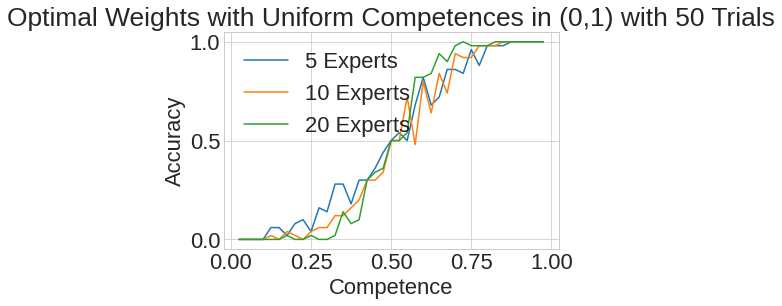

<Figure size 432x288 with 0 Axes>

In [30]:
NUM_VOTERS = 100
NUM_EXPERTS = [5, 10, 20]
NUM_TRIALS = 50 #30,000

np.random.seed(11221993)

means = np.arange(0.025, 1.0, 0.025)

accuracies = {}
for num_exp in NUM_EXPERTS:
  accuracies[num_exp] = []

  for mean in means:
    if(mean != 0.5):
      num_correct = 0
      profile = Profile(num_exp, NUM_VOTERS)
      for i in range(NUM_TRIALS):
        expert_competences = generate_gaussian_competences(mean, 0, num_exp)
        profile.set_expert_competences(expert_competences)
        profile.set_optimal_expert_weights()
        profile.generate_expert_votes()
        profile.weighted_majority_vote()
        if(profile.get_outcome() == 1):
          num_correct = num_correct + 1
      accuracies[num_exp].append(num_correct / NUM_TRIALS)
    elif(mean == 0.5):
      accuracies[num_exp].append(0.5)

plt.xlabel("Competence")
plt.ylabel("Accuracy")
title = "Optimal Weights with Uniform Competences in (0,1) with {} Trials".format(NUM_TRIALS)
plt.title(title)
for key in accuracies.keys():
  plt.plot(means, accuracies[key], label="{} Experts".format(key))
plt.legend()
plt.show()
plot_title = title+".png"
# plt.savefig(plot_title)

# data_title = title.replace(" ", "_")
# data_title = data_title+".csv"


# uniform_competences_df = pd.DataFrame(np.array([means, accuracies]).T, columns=["Competence","Accuracy"])
# print(uniform_competences_df)

# uniform_competences_df.to_csv(data_title)



#EXPERIMENT 1.2 (Uniform Expert Competences, Non-negative Weights)
Repeat experiment 1.1 but do not allow experts to receive negative weights.

#EXPERIMENT 2.1 (Gaussian Expert Competences)
Given a fixed number of experts, with competences drawn from a normal distribution (mu, sigma), look at how the accuracy of their weighted majority vote depends on mu and sigma. 


### RESULTS

1. Plot a separate line for each variance (accuracy vs. mean competence)(include variance = 0).
2. Plot a line for each mean competence (accuracy vs. variance).

#EXPERIMENT 2.2
Repeat Experiment 2.1 but do not allow experts to receive negative weights

#EXPERIMENT 3 (Delegation with Gaussian Estimates)

Given a fixed number of experts and voters, with uniform expert competences, and voter estimates of competences come from a Gaussian distribution (mu, sigma) with the correct mean (unbiased), compare delegation weights to optimal weights and equal weights. Do not allow delegated weights to be negative.

#EXPERIMENT 4 (Delegation where Estimates have Gaussian Errors)

Given a fixed number of experts and voters, with uniform expert competences, and voter estimates of competences have Gaussian noise -- so there is some error e drawn from N(mu, sigma) added to the correct competence for each estimate -- compare delegation weights to optimal weights and equal weights. Do not allow delegated weights to be negative.

#EXPERIMENT 5 (Normalization)

Repeat the experiments above involving delegation (3rd and 4th) but now require that each voter assign weights that sum to 1 (so normalize weights from each voter before aggregating).


#EXPERIMENT 6.1 (Partial Participation)
Repeat the experiments involving delegation (3rd and 4th), but now assume that voters only participate by assigning weights with probability ***equal*** to their competence

#EXPERIMENT 6.2 (Partial Participation with Dunning-Kreuger)
Repeat one of the experiments involving delegation (3rd or 4th), but now assume that voters only participate by assigning weights with probability ***inversely proportional*** to their competence

#EXPERIMENT 6.3 (FRD)
Repeat experiments 6.1 and 6.2 but with a uniform default distribution used by the voters who do not actively participate.

#DRIVER (For Easy Testing, Parallelization, Writing to File, and Downloading)

#OTHER/OLD

[0.9126, 0.92476, 0.93038, 0.93386, 0.93486, 0.93718, 0.93608, 0.93714, 0.93772]


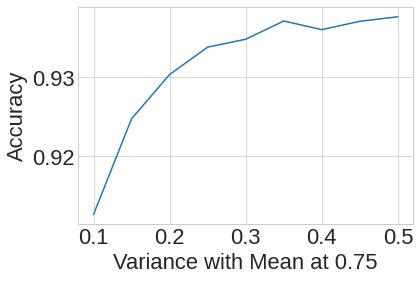

In [ ]:
# NUM_VOTERS = 100
# NUM_EXPERTS = 5
# NUM_TRIALS = 50000 #50,000
# #Need like 100,000 iterations to make the curve smooth. 
# #50,000 took 2 min without parallelization


# means = np.arange(0.5, 1.05, 0.025)
# variances = np.arange(0.1, 0.55, 0.05)


# accuracies = []
# for variance in variances:
#   num_correct = 0
#   profile = Profile(NUM_EXPERTS, NUM_VOTERS)
#   for i in range(NUM_TRIALS):
#     competences = generate_gaussian_competences(0.75, variance, NUM_EXPERTS)
#     profile.set_expert_competences(competences)
#     profile.set_optimal_expert_weights()
#     profile.generate_expert_votes()
#     profile.weighted_majority_vote()
#     if(profile.get_outcome() == 1):
#       num_correct = num_correct + 1
#   accuracies.append(num_correct / NUM_TRIALS)

# print(accuracies)
# plt.xlabel("Variance with Mean at 0.75")
# plt.ylabel("Accuracy")
# plt.plot(variances, accuracies)
# plt.show()

##SECOND AND THIRD EXPERIMENT
Assume that voter estimates of expert competences are drawn from Gaussian distribution with mean equal to their true competence, and look at accuracy of the weighting when voters assign what they believe to be the optimal weights.

Next, do the same thing, but normalize the weights before they are summed up

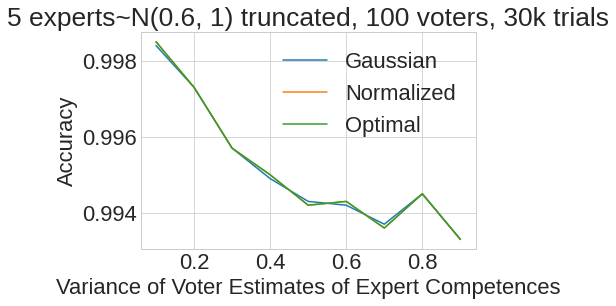

In [ ]:
# NUM_VOTERS = 500
# NUM_EXPERTS = 20
# NUM_TRIALS = 10000

# competence_mean = 0.6
# competence_variance = 1
# estimate_variances = np.arange(0.1, 1, 0.1)


# accuracies_gaussian_estimates = []
# accuracies_gaussian_normalized = []
# accuracies_optimal_weights = []

# for ev in estimate_variances:

#   num_correct_gaussian_estimates = 0
#   num_correct_gaussian_normalized = 0
#   num_correct_optimal_weights = 0
#   profile = Profile(NUM_EXPERTS, NUM_VOTERS)

#   for i in range(NUM_TRIALS):
#     competences = generate_gaussian_competences(competence_mean, competence_variance, profile.get_num_experts())
#     profile.set_expert_competences(competences)
#     for x in range(NUM_EXPERTS):
#       competence_estimates = generate_gaussian_competences(competences[x], ev, profile.get_num_voters())
#       delegated_weights = np.log(competence_estimates / (1 - competence_estimates))
#       for v in range(profile.get_num_voters()):
#         profile.set_delegations_single_pair(v, x, delegated_weights[v])

#     profile.generate_expert_votes()


#     profile.sum_delegations()
#     profile.weighted_majority_vote()
#     if(profile.get_outcome() == 1):
#       num_correct_gaussian_estimates = num_correct_gaussian_estimates + 1
    

#     profile.normalize_delegations()
#     profile.sum_delegations()
#     profile.weighted_majority_vote()
#     if(profile.get_outcome() == 1):
#       num_correct_gaussian_normalized = num_correct_gaussian_normalized + 1
    

#     profile.set_optimal_expert_weights()
#     profile.weighted_majority_vote()
#     if(profile.get_outcome() == 1):
#       num_correct_optimal_weights = num_correct_optimal_weights + 1


#   accuracies_gaussian_estimates.append(num_correct_gaussian_estimates / NUM_TRIALS)
#   accuracies_gaussian_normalized.append(num_correct_gaussian_normalized / NUM_TRIALS)
#   accuracies_optimal_weights.append(num_correct_gaussian_normalized / NUM_TRIALS)


# plt.xlabel("Variance of Voter Estimates of Expert Competences")
# plt.ylabel("Accuracy")
# plt.plot(estimate_variances, accuracies_gaussian_estimates)
# plt.plot(estimate_variances, accuracies_gaussian_normalized)
# plt.plot(estimate_variances, accuracies_optimal_weights)
# plt.legend(["Gaussian", "Normalized", "Optimal"])
# plt.title("20 experts~N(0.6, 1) truncated, 500 voters, 10k trials")
# plt.show()





In [ ]:
# #TESTING AREA

# #np.random.seed(11221993)

# profile = Profile(20, 100)

# num_correct = 0
# num_trials = 1
# for i in range(num_trials):
#   competences = generate_gaussian_competences(0.55, 0.0001, 20)
#   print(competences)
#   profile.set_expert_competences(competences)
#   print(profile.get_expert_competences())
# #profile.get_expert_competences()
#   profile.set_optimal_expert_weights()
#   print(profile.get_expert_weights())
# #profile.get_expert_weights()
#   profile.generate_expert_votes()
#   print(profile.get_expert_votes())
#   profile.weighted_majority_vote()
#   if(profile.get_outcome() == 1):
#     num_correct = num_correct + 1

# print(num_correct / num_trials)

# print(np.dot(profile.get_expert_votes(), profile.get_expert_weights()))
# print(np.sum(profile.get_expert_weights()))



[0.5500965  0.55007495 0.54998066 0.54979353 0.54988811 0.5501594
 0.55007274 0.54982618 0.55015952 0.55005468 0.55000873 0.54997213
 0.55019642 0.55008784 0.5500678  0.55006152 0.55020031 0.54994273
 0.5499922  0.54994259]
[0.5500965  0.55007495 0.54998066 0.54979353 0.54988811 0.5501594
 0.55007274 0.54982618 0.55015952 0.55005468 0.55000873 0.54997213
 0.55019642 0.55008784 0.5500678  0.55006152 0.55020031 0.54994273
 0.5499922  0.54994259]
[0.20106060199218742, 0.20097354744342644, 0.20059255546923113, 0.19983651663251706, 0.200218638650116, 0.20131477008782908, 0.20096458395852848, 0.19996840814260547, 0.2013152516221068, 0.20089164151163155, 0.20070597047865846, 0.20055807143044146, 0.2014643380654235, 0.20102562651007408, 0.20094462406075647, 0.2009192756267389, 0.2014800527226037, 0.20043930362524484, 0.2006391890350754, 0.20043873637843826]
[0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0]
1.0
2.4109035628081505
4.015751703443635
